In [1]:
import qutip as q
import numpy as np
import subprocess
import ffmpeg
import pickle
import cv2
import os
import re

%matplotlib inline
from matplotlib import rc
from matplotlib import pyplot as plt
font = {'weight' : 'normal',
        'size'   : 18}
rc('font', **font)

from matplotlib.font_manager import FontProperties

##### $H_{rot}= \Omega * S_x + \gamma_{n} *B_0*I_z + \hat{S}*A*\hat{I}$

In [2]:
# NV hamiltonian
sz = q.sigmaz()
sx = q.sigmax()
sy = q.sigmay()


#a is the azimutal angle theta
a=90
a /= 180.0/np.pi

#b is the initial phase angle 
b = 270
b /= 180.0/np.pi



#np.exp((0 + 1j) * b * 0.5)
#* np.exp(-(0 + 1j) * b * 0.5)
#initial state
phi = np.cos(a/2.)  * q.basis(2,0)+ np.exp(-(0 + 1j) * b) * np.sin(a/2.) * q.basis(2,1)
print(phi)


rho_nv = phi*phi.dag()
print(rho_nv)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.70710678+0.j        ]
 [ 0.00000000+0.70710678j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5+0.j   0.0-0.5j]
 [ 0.0+0.5j  0.5+0.j ]]


15.7079632679


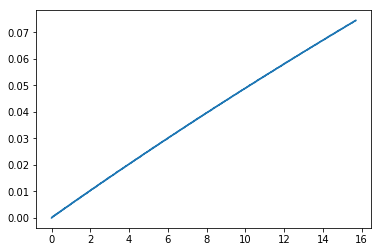

In [3]:
Hdc = 0 * sy #-g*(sigma_ge.dag()*a + a.dag()*sigma_ge)

omega2 = 10

on_off = 0.5
omega = (1 - on_off) * omega2 * 0.01
Hx = omega * sx
Hy = omega * sy
omegaz = omega2 
Hz = omegaz * sz

time_x= 0.5 * np.pi * 10
t = np.linspace(0, time_x, 1000)

print(np.max(t))


delta = np.pi /float(2 ) * 100
omegaz = delta * 3.8317 * 10
Hz = omegaz * sz
phase = np.pi * 0.7


def Hx_coeff(t,args):
    delta = args['dw'] 
    phase = args['phase']
    return np.sqrt(3) * np.sin(1*delta * t + phase)

def Hy_coeff(t,args):
    delta = args['dw'] 
    phase = args['phase']
    return np.sqrt(3) * np.cos(1*delta * t + phase)

def Hz_coeff(t,args):
    delta = args['dw'] 
    phase = args['phase']
    return on_off * np.sqrt(3) * np.cos( delta * t + 1* np.pi)


H = [Hdc,[Hx,Hx_coeff],[Hy,Hy_coeff],[Hz,Hz_coeff]]
     
psi = np.cos(a/2.)*q.basis(2,0)+ (1 + 0j) * np.sin(a/2.)*q.basis(2,1)

dw = delta

#output = mesolve(H, psi0, t, c_ops, [ada, sigma_UU, sigma_GG]
#q.mesolve(H=H0, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000))
output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=1000000), args={'dw': dw, 'phase': phase})

plt.plot(t,q.expect(output.states, sz))
#plot_y = q.expect(output.states, sz) # / 0.06

0.0004


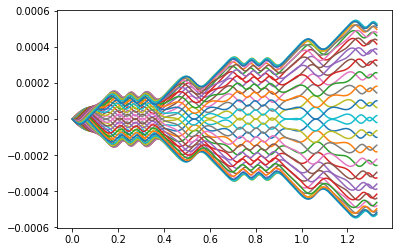

In [4]:
Hdc = 0 * sy #-g*(sigma_ge.dag()*a + a.dag()*sigma_ge)

on_off = 0.5
last = []
xdata = []
for k in range(41):
    
    omega = (1 - on_off) * omega2 * 0.00002 * 40 #(k+1)
    Hx = omega * sx
    Hy = omega * sy
    omegaz = omega2 
    Hz = omegaz * sz

    time_x=9000*np.pi/Omega
    t = np.linspace(0, time_x, 1000)

    
    
    delta = np.pi /float(2  * time_x) * 10
    omegaz = delta * 3.6
    
    Hz = omegaz * sz
    phase = np.pi * k/20.0

    harmonic = 16 / 8.0
    
    
    def Hx_coeff(t,args):
        delta = args['dw'] 
        phase = args['phase']
        return np.sqrt(3) * np.sin(harmonic *delta * t + phase)

    def Hy_coeff(t,args):
        delta = args['dw'] 
        phase = args['phase']
        return np.sqrt(3) * np.cos(harmonic * delta * t + phase)

    def Hz_coeff(t,args):
        delta = args['dw'] 
        phase = args['phase']
        return on_off * np.sqrt(3) * np.cos( delta * t + 1* np.pi)


    H = [Hdc,[Hx,Hx_coeff],[Hy,Hy_coeff],[Hz,Hz_coeff]]

    psi = np.cos(a/2.)*q.basis(2,0)+ (1 + 0j) * np.sin(a/2.)*q.basis(2,1)

    dw = delta

    #output = mesolve(H, psi0, t, c_ops, [ada, sigma_UU, sigma_GG]
    #q.mesolve(H=H0, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000))
    output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000), args={'dw': dw, 'phase': phase})
    data = q.expect(output.states, sz)
    plt.plot(t,data)
    last.append(data[-1])
    xdata.append(phase)
print(omega)

In [5]:
print(omega,omegaz)

(0.0004, 42.57600000000001)


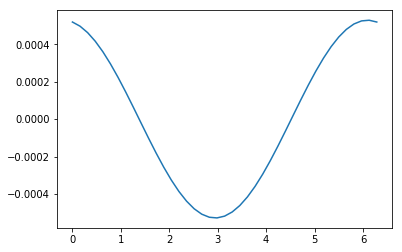

In [6]:
plt.plot(xdata,last)
#print(last)

### Pulsed Mollow Stuff

In [2]:
Axx=65*10**3 # 20 kHz
B0=500.0 # Gauss
gamma_nuc = 42.576*1000000 # Hz/T
w_larmor=B0*gamma_nuc/10000

Omega = w_larmor / 100.0

time_x=0.5*np.pi/Omega

# NV hamiltonian
sz = q.sigmaz()
sx = q.sigmax()
sy = q.sigmay()

#rho_nv = q.thermal_dm(2, 0.0) # initialized to 0 temperature


a=90.0
a /= 180.0/np.pi
phi = np.cos(a/2.)*q.basis(2,0)+ (1 + 0j) * np.sin(a/2.)*q.basis(2,1)

rho_nv = phi*phi.dag()

print(rho_nv)



H0 = Omega * sx 

delta = 0# np.pi /float(time_x)
print(delta * time_x)
alpha = np.pi/200000
omega = Omega * 0.1
H1 = omega * (np.sin(alpha) * sx + np.cos(alpha) * sy) + delta * sz

print(omega,delta,'Hi Jonas')

t = np.linspace(0, time_x, 500)
#(-1)**(k) *
resultat = []
N = 50
for k in range(N):
    if k == 0:
        resultat.append(q.mesolve(H=H0, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))
        resultat.append(q.mesolve(H=H1, rho0=resultat[-1].states[-1], tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))
    else:
        H1 = (-1)**(k) * omega * (np.sin(alpha) * sx + np.cos(alpha) * sy)#+  delta * sz
        resultat.append(q.mesolve(H=H0, rho0=resultat[-1].states[-1], tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))
        resultat.append(q.mesolve(H=H1, rho0=resultat[-1].states[-1], tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))



Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0.5]
 [ 0.5  0.5]]
0.0
(2128.8, 0, 'Hi Jonas')


In [2]:
Axx=65*10**3 # 20 kHz
B0=500.0 # Gauss
gamma_nuc = 42.576*1000000 # Hz/T
w_larmor=B0*gamma_nuc/10000

Omega = w_larmor / 100.0

time_x=0.5*np.pi/Omega

# NV hamiltonian
sz = q.sigmaz()
sx = q.sigmax()
sy = q.sigmay()

#rho_nv = q.thermal_dm(2, 0.0) # initialized to 0 temperature


a=90.0
a /= 180.0/np.pi
phi = np.cos(a/2.)*q.basis(2,0)+ (1 + 0j) * np.sin(a/2.)*q.basis(2,1)

rho_nv = phi*phi.dag()

print(rho_nv)



H0 = Omega * sx 

delta = 0# np.pi /float(time_x)
print(delta * time_x)
alpha = np.pi/200000
omega = Omega * 0.1
H1 = omega * (np.sin(alpha) * sx + np.cos(alpha) * sy) + delta * sz

print(omega,delta,'Hi Jonas')

t = np.linspace(0, time_x, 500)
#(-1)**(k) *
resultat = []
N = 50
for k in range(N):
    if k == 0:
        resultat.append(q.mesolve(H=H0, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))
        resultat.append(q.mesolve(H=H1, rho0=resultat[-1].states[-1], tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))
    else:
        H1 = (-1)**(k) * omega * (np.sin(alpha) * sx + np.cos(alpha) * sy)#+  delta * sz
        resultat.append(q.mesolve(H=H0, rho0=resultat[-1].states[-1], tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))
        resultat.append(q.mesolve(H=H1, rho0=resultat[-1].states[-1], tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))



Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0.5]
 [ 0.5  0.5]]
0.0
(2128.8, 0, 'Hi Jonas')


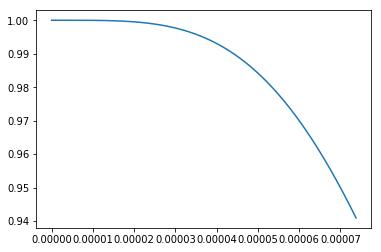

In [5]:
Hdc = 0 * sy #-g*(sigma_ge.dag()*a + a.dag()*sigma_ge)
Hx = omega * sx
Hy = omega * sy

delta = np.pi /float(2  *time_x)
phase = np.pi /2.

def Hx_coeff(t,args):
    delta = args['dw'] 
    phase = args['phase']
    return np.sqrt(3) * np.sin(delta * t + phase)

def Hy_coeff(t,args):
    delta = args['dw'] 
    phase = args['phase']
    return np.sqrt(3) * np.cos(delta * t + phase)

H = [Hdc,[Hx,Hx_coeff],[Hy,Hy_coeff]]
     
psi = np.cos(a/2.)*q.basis(2,0)+ (1 + 0j) * np.sin(a/2.)*q.basis(2,1)

dw = delta

#output = mesolve(H, psi0, t, c_ops, [ada, sigma_UU, sigma_GG]
#q.mesolve(H=H0, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000))
output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000), args={'dw': dw, 'phase': phase})

plt.plot(t,q.expect(output.states, sx))

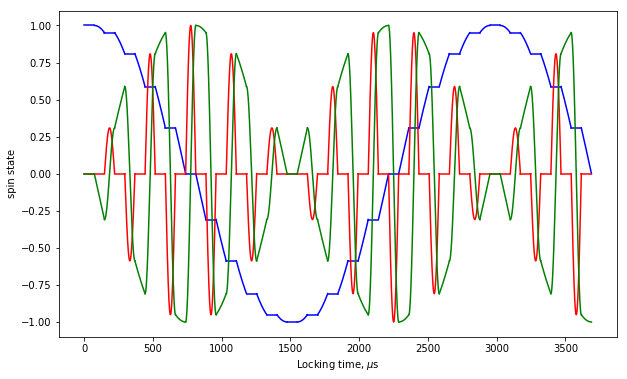

In [3]:

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)



#resultat = resultat1

for k in range(N):
    ax.plot(t*1e+6 + k * time_x * 1e+6, q.expect(resultat[k].states, sx),label='sx',color = 'b')
    ax.plot(t*1e+6 + k * time_x * 1e+6, q.expect(resultat[k].states, sy),label='sy', color = 'r')
    ax.plot(t*1e+6 + k * time_x * 1e+6, q.expect(resultat[k].states, sz),label='sz', color = 'g')





#ax.plot(t*1e+6, q.expect(resultat.states, iz),label='iz')
#ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
#ax.legend(loc='upper right')

ax.set_ylabel('spin state')
ax.set_xlabel(r'Locking time, $\mu$s')
plt.show()
#fig.savefig('polarization.png', bbox_inches='tight', dpi=300)

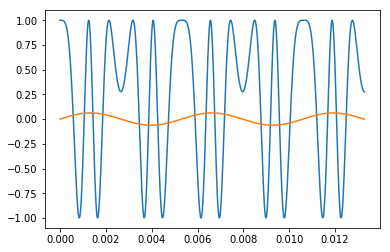

In [94]:
plt.plot(t,q.expect(output.states, sx))
plt.plot(t,plot_y)

In [406]:
Axx=65*10**3 # 20 kHz
B0=500.0 # Gauss
gamma_nuc = 42.576*1000000 # Hz/T
w_larmor=B0*gamma_nuc/10000

Omega = w_larmor / 100.0

time_x=0.5*np.pi/Omega

# NV hamiltonian
sz = q.sigmaz()
sx = q.sigmax()
sy = q.sigmay()

#rho_nv = q.thermal_dm(2, 0.0) # initialized to 0 temperature


a=90.0
a /= 180.0/np.pi
phi = np.cos(a/2.)*q.basis(2,0)+ (1 + 0j) * np.sin(a/2.)*q.basis(2,1)

rho_nv = phi*phi.dag()

print(rho_nv)



H0 = Omega * sx 

delta = 0# np.pi /float(time_x)
print(delta * time_x)
alpha = np.pi/4.
omega = Omega * 0.1
H1 = omega * (np.sin(alpha) * sx + np.cos(alpha) * sy) + delta * sz

t = np.linspace(0, time_x, 500)
#(-1)**(k) *
resultat = []
N = 10
dw = 2 * Omega * 1
phase =  np.pi/ 2.0 * 3.0
for k in range(N):
    if k == 0:
        resultat.append(q.mesolve(H=H0, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))
        resultat.append(q.mesolve(H=H, rho0=resultat[-1].states[-1], tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000), args={'dw': dw, 'phase': phase}))
    else:
        H1 = (-1)**(k) * omega * (np.sin(alpha) * sx + np.cos(alpha) * sy)#+  delta * sz
        resultat.append(q.mesolve(H=H0, rho0=resultat[-1].states[-1], tlist=t + k * time_x, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))
        resultat.append(q.mesolve(H=H, rho0=resultat[-1].states[-1], tlist=t + k * time_x, c_ops = [], e_ops=[], options=q.Options(nsteps=100000), args={'dw': dw, 'phase': phase}))


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0.5]
 [ 0.5  0.5]]
0.0


-0.986119557303


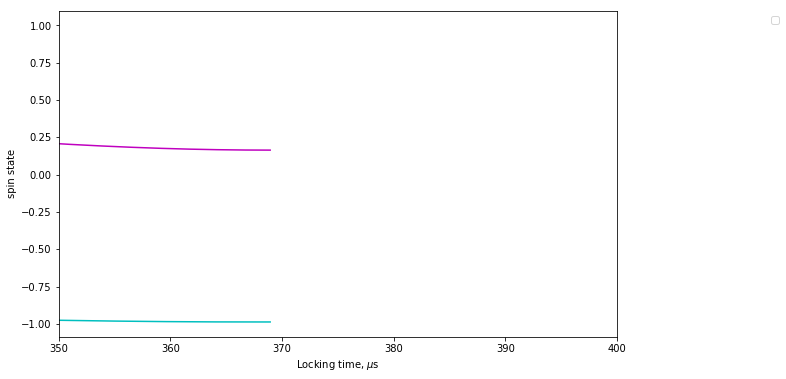

In [410]:

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)



#resultat = resultat1

for k in range(N):
    if k%2 == 0:
        continue
        #ax.plot(t*1e+6 + k * time_x * 1e+6, q.expect(resultat[k].states, sx),label='sx',color = 'b')
        #ax.plot(t*1e+6 + k * time_x * 1e+6, q.expect(resultat[k].states, sy),label='sy', color = 'r')
        #ax.plot(t*1e+6 + k * time_x * 1e+6, q.expect(resultat[k].states, sz),label='sz', color = 'g')
    else:
        ki = k/2
        ax.plot(t*1e+6 + ki * time_x * 1e+6, q.expect(resultat[k].states, sx), color = 'm')
        #ax.plot(t*1e+6 + ki * time_x * 1e+6, q.expect(resultat[k].states, sy), color = 'y')
        ax.plot(t*1e+6 + ki * time_x * 1e+6, q.expect(resultat[k].states, sz), color = 'c')

print(q.expect(resultat[k].states, sz)[-1])



#ax.plot(t*1e+6, q.expect(resultat.states, iz),label='iz')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
#ax.legend(loc='upper right')

ax.set_ylabel('spin state')
ax.set_xlabel(r'Locking time, $\mu$s')
plt.xlim([350,400])
plt.show()
#fig.savefig('polarization.png', bbox_inches='tight', dpi=300)

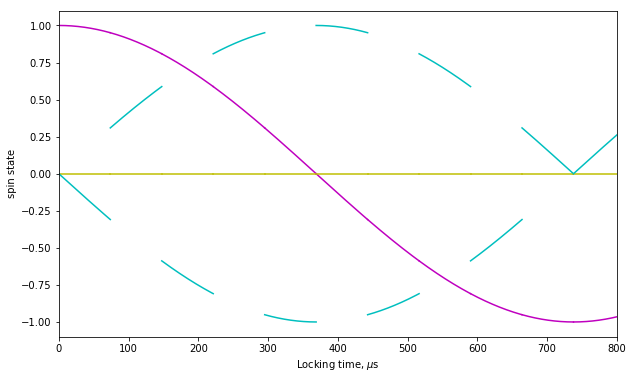

In [286]:

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)



#resultat = resultat1

for k in range(N):
    if k%2 == 0:
        continue
        ax.plot(t*1e+6 + k * time_x * 1e+6, q.expect(resultat[k].states, sx),label='sx',color = 'b')
        ax.plot(t*1e+6 + k * time_x * 1e+6, q.expect(resultat[k].states, sy),label='sy', color = 'r')
        ax.plot(t*1e+6 + k * time_x * 1e+6, q.expect(resultat[k].states, sz),label='sz', color = 'g')
    else:
        ki = k/2
        ax.plot(t*1e+6 + ki * time_x * 1e+6, q.expect(resultat[k].states, sx),label='sx',color = 'm')
        ax.plot(t*1e+6 + ki * time_x * 1e+6, q.expect(resultat[k].states, sy),label='sy', color = 'y')
        ax.plot(t*1e+6 + ki * time_x * 1e+6, q.expect(resultat[k].states, sz),label='sz', color = 'c')




#ax.plot(t*1e+6, q.expect(resultat.states, iz),label='iz')
#ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
#ax.legend(loc='upper right')

ax.set_ylabel('spin state')
ax.set_xlabel(r'Locking time, $\mu$s')
plt.xlim([0,800])
plt.show()
#fig.savefig('polarization.png', bbox_inches='tight', dpi=300)

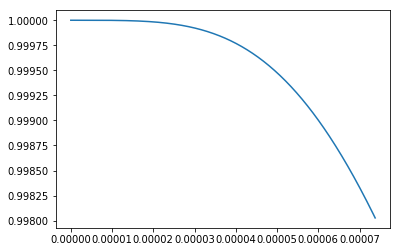

In [527]:
Hdc = 0 * sy #-g*(sigma_ge.dag()*a + a.dag()*sigma_ge)
Hx = omega * sx
Hy = omega * sy

delta = np.pi /float(2  *time_x)
phase = np.pi /2.

def Hx_coeff(t,args):
    delta = args['dw'] 
    phase = args['phase']
    return np.pi * 0.5 * np.sin(delta * t + phase) * 0.2

def Hy_coeff(t,args):
    delta = args['dw'] 
    phase = args['phase']
    return np.pi * 0.5 * np.cos(delta * t + phase) * 0.2

H = [Hdc,[Hx,Hx_coeff],[Hy,Hy_coeff]]
     
psi = np.cos(a/2.)*q.basis(2,0)+ (1 + 0j) * np.sin(a/2.)*q.basis(2,1)

dw = delta

#output = mesolve(H, psi0, t, c_ops, [ada, sigma_UU, sigma_GG]
#q.mesolve(H=H0, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000))
output = q.mesolve(H=H, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000), args={'dw': dw, 'phase': phase})

plt.plot(t,q.expect(output.states, sx))

In [528]:
def solve_mollow(t,N,d_prime,phase):
    resultat = []
    dw = 2 * Omega * d_prime
    fast = True
    for k in range(N):
        if k == 0:
                resultat_0 = (q.mesolve(H=H0, rho0=rho_nv, tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))
                resultat_1 = (q.mesolve(H=H, rho0=resultat_0.states[-1], tlist=t, c_ops = [], e_ops=[], options=q.Options(nsteps=100000), args={'dw': dw, 'phase': phase}))
        else:
                resultat_0 = (q.mesolve(H=H0, rho0=resultat_1.states[-1], tlist=t + k * time_x, c_ops = [], e_ops=[], options=q.Options(nsteps=100000)))
                resultat_1 = (q.mesolve(H=H, rho0=resultat_0.states[-1], tlist=t + k * time_x, c_ops = [], e_ops=[], options=q.Options(nsteps=100000), args={'dw': dw, 'phase': phase}))
    return q.expect(resultat_1.states[-1], sz)

In [530]:
Axx=65*10**3 # 20 kHz
B0=500.0 # Gauss
gamma_nuc = 42.576*1000000 # Hz/T
w_larmor=B0*gamma_nuc/10000

Omega = w_larmor / 100.0

time_x=0.5*np.pi/Omega

# NV hamiltonian
sz = q.sigmaz()
sx = q.sigmax()
sy = q.sigmay()

#rho_nv = q.thermal_dm(2, 0.0) # initialized to 0 temperature


a=90.0
a /= 180.0/np.pi
phi = np.cos(a/2.)*q.basis(2,0)+ (1 + 0j) * np.sin(a/2.)*q.basis(2,1)

rho_nv = phi*phi.dag()

print(rho_nv)



H0 = Omega * sx 

delta = 0# np.pi /float(time_x)
print(delta * time_x)
alpha = np.pi/4.
omega = Omega * 0.1
H1 = omega * (np.sin(alpha) * sx + np.cos(alpha) * sy) + delta * sz

t = np.linspace(0, time_x, 500)
#(-1)**(k) *
N = 4
dw = 2 * Omega * 1.1


dp = 2.0 #variation of delta
points = 36
p = 160
phases = np.arange(points +1 ) / float(points) * np.pi * 2.0
d_primes = (np.arange(p) - p/2.)*2 * dp / p #+ 1.0


populations = np.empty([len(phases),len(d_primes)])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0.5]
 [ 0.5  0.5]]
0.0


In [531]:
counter= 0
N = 15
for k in range(len(phases)):
    phase = phases[k]
    for j in range(len(d_primes)):
        d_prime = d_primes[j]
        print('N, dp, phase', counter,d_prime,phase)
        #resultat = solve_mollow(t,N,d_prime,phase)
        #populations[k][j] = q.expect(resultat[-1].states[-1], sz)
        populations[k][j] = solve_mollow(t,N,d_prime,phase)
        counter += 1
phase =  np.pi/ 2.0 * 3.0

print(populations)


#resultat = solve_mollow(t,N,1.0,phase)

('N, dp, phase', 0, -2.0, 0.0)
('N, dp, phase', 1, -1.9750000000000001, 0.0)
('N, dp, phase', 2, -1.95, 0.0)
('N, dp, phase', 3, -1.925, 0.0)
('N, dp, phase', 4, -1.8999999999999999, 0.0)
('N, dp, phase', 5, -1.875, 0.0)
('N, dp, phase', 6, -1.8500000000000001, 0.0)
('N, dp, phase', 7, -1.825, 0.0)
('N, dp, phase', 8, -1.8, 0.0)
('N, dp, phase', 9, -1.7749999999999999, 0.0)
('N, dp, phase', 10, -1.75, 0.0)
('N, dp, phase', 11, -1.7250000000000001, 0.0)
('N, dp, phase', 12, -1.7, 0.0)
('N, dp, phase', 13, -1.675, 0.0)
('N, dp, phase', 14, -1.6499999999999999, 0.0)
('N, dp, phase', 15, -1.625, 0.0)
('N, dp, phase', 16, -1.6000000000000001, 0.0)
('N, dp, phase', 17, -1.575, 0.0)
('N, dp, phase', 18, -1.55, 0.0)
('N, dp, phase', 19, -1.5249999999999999, 0.0)
('N, dp, phase', 20, -1.5, 0.0)
('N, dp, phase', 21, -1.4750000000000001, 0.0)
('N, dp, phase', 22, -1.45, 0.0)
('N, dp, phase', 23, -1.425, 0.0)
('N, dp, phase', 24, -1.3999999999999999, 0.0)
('N, dp, phase', 25, -1.375, 0.0)
('N, dp,

('N, dp, phase', 188, -1.3, 0.17453292519943295)
('N, dp, phase', 189, -1.2749999999999999, 0.17453292519943295)
('N, dp, phase', 190, -1.25, 0.17453292519943295)
('N, dp, phase', 191, -1.2250000000000001, 0.17453292519943295)
('N, dp, phase', 192, -1.2, 0.17453292519943295)
('N, dp, phase', 193, -1.175, 0.17453292519943295)
('N, dp, phase', 194, -1.1499999999999999, 0.17453292519943295)
('N, dp, phase', 195, -1.125, 0.17453292519943295)
('N, dp, phase', 196, -1.1000000000000001, 0.17453292519943295)
('N, dp, phase', 197, -1.075, 0.17453292519943295)
('N, dp, phase', 198, -1.05, 0.17453292519943295)
('N, dp, phase', 199, -1.0249999999999999, 0.17453292519943295)
('N, dp, phase', 200, -1.0, 0.17453292519943295)
('N, dp, phase', 201, -0.97499999999999998, 0.17453292519943295)
('N, dp, phase', 202, -0.94999999999999996, 0.17453292519943295)
('N, dp, phase', 203, -0.92500000000000004, 0.17453292519943295)
('N, dp, phase', 204, -0.90000000000000002, 0.17453292519943295)
('N, dp, phase', 205

('N, dp, phase', 328, -1.8, 0.3490658503988659)
('N, dp, phase', 329, -1.7749999999999999, 0.3490658503988659)
('N, dp, phase', 330, -1.75, 0.3490658503988659)
('N, dp, phase', 331, -1.7250000000000001, 0.3490658503988659)
('N, dp, phase', 332, -1.7, 0.3490658503988659)
('N, dp, phase', 333, -1.675, 0.3490658503988659)
('N, dp, phase', 334, -1.6499999999999999, 0.3490658503988659)
('N, dp, phase', 335, -1.625, 0.3490658503988659)
('N, dp, phase', 336, -1.6000000000000001, 0.3490658503988659)
('N, dp, phase', 337, -1.575, 0.3490658503988659)
('N, dp, phase', 338, -1.55, 0.3490658503988659)
('N, dp, phase', 339, -1.5249999999999999, 0.3490658503988659)
('N, dp, phase', 340, -1.5, 0.3490658503988659)
('N, dp, phase', 341, -1.4750000000000001, 0.3490658503988659)
('N, dp, phase', 342, -1.45, 0.3490658503988659)
('N, dp, phase', 343, -1.425, 0.3490658503988659)
('N, dp, phase', 344, -1.3999999999999999, 0.3490658503988659)
('N, dp, phase', 345, -1.375, 0.3490658503988659)
('N, dp, phase', 3

('N, dp, phase', 470, 1.75, 0.3490658503988659)
('N, dp, phase', 471, 1.7749999999999999, 0.3490658503988659)
('N, dp, phase', 472, 1.8, 0.3490658503988659)
('N, dp, phase', 473, 1.825, 0.3490658503988659)
('N, dp, phase', 474, 1.8500000000000001, 0.3490658503988659)
('N, dp, phase', 475, 1.875, 0.3490658503988659)
('N, dp, phase', 476, 1.8999999999999999, 0.3490658503988659)
('N, dp, phase', 477, 1.925, 0.3490658503988659)
('N, dp, phase', 478, 1.95, 0.3490658503988659)
('N, dp, phase', 479, 1.9750000000000001, 0.3490658503988659)
('N, dp, phase', 480, -2.0, 0.52359877559829882)
('N, dp, phase', 481, -1.9750000000000001, 0.52359877559829882)
('N, dp, phase', 482, -1.95, 0.52359877559829882)
('N, dp, phase', 483, -1.925, 0.52359877559829882)
('N, dp, phase', 484, -1.8999999999999999, 0.52359877559829882)
('N, dp, phase', 485, -1.875, 0.52359877559829882)
('N, dp, phase', 486, -1.8500000000000001, 0.52359877559829882)
('N, dp, phase', 487, -1.825, 0.52359877559829882)
('N, dp, phase', 4

('N, dp, phase', 610, 1.25, 0.52359877559829882)
('N, dp, phase', 611, 1.2749999999999999, 0.52359877559829882)
('N, dp, phase', 612, 1.3, 0.52359877559829882)
('N, dp, phase', 613, 1.325, 0.52359877559829882)
('N, dp, phase', 614, 1.3500000000000001, 0.52359877559829882)
('N, dp, phase', 615, 1.375, 0.52359877559829882)
('N, dp, phase', 616, 1.3999999999999999, 0.52359877559829882)
('N, dp, phase', 617, 1.425, 0.52359877559829882)
('N, dp, phase', 618, 1.45, 0.52359877559829882)
('N, dp, phase', 619, 1.4750000000000001, 0.52359877559829882)
('N, dp, phase', 620, 1.5, 0.52359877559829882)
('N, dp, phase', 621, 1.5249999999999999, 0.52359877559829882)
('N, dp, phase', 622, 1.55, 0.52359877559829882)
('N, dp, phase', 623, 1.575, 0.52359877559829882)
('N, dp, phase', 624, 1.6000000000000001, 0.52359877559829882)
('N, dp, phase', 625, 1.625, 0.52359877559829882)
('N, dp, phase', 626, 1.6499999999999999, 0.52359877559829882)
('N, dp, phase', 627, 1.675, 0.52359877559829882)
('N, dp, phase',

('N, dp, phase', 751, 0.77500000000000002, 0.69813170079773179)
('N, dp, phase', 752, 0.80000000000000004, 0.69813170079773179)
('N, dp, phase', 753, 0.82499999999999996, 0.69813170079773179)
('N, dp, phase', 754, 0.84999999999999998, 0.69813170079773179)
('N, dp, phase', 755, 0.875, 0.69813170079773179)
('N, dp, phase', 756, 0.90000000000000002, 0.69813170079773179)
('N, dp, phase', 757, 0.92500000000000004, 0.69813170079773179)
('N, dp, phase', 758, 0.94999999999999996, 0.69813170079773179)
('N, dp, phase', 759, 0.97499999999999998, 0.69813170079773179)
('N, dp, phase', 760, 1.0, 0.69813170079773179)
('N, dp, phase', 761, 1.0249999999999999, 0.69813170079773179)
('N, dp, phase', 762, 1.05, 0.69813170079773179)
('N, dp, phase', 763, 1.075, 0.69813170079773179)
('N, dp, phase', 764, 1.1000000000000001, 0.69813170079773179)
('N, dp, phase', 765, 1.125, 0.69813170079773179)
('N, dp, phase', 766, 1.1499999999999999, 0.69813170079773179)
('N, dp, phase', 767, 1.175, 0.69813170079773179)
('

('N, dp, phase', 892, 0.29999999999999999, 0.87266462599716477)
('N, dp, phase', 893, 0.32500000000000001, 0.87266462599716477)
('N, dp, phase', 894, 0.34999999999999998, 0.87266462599716477)
('N, dp, phase', 895, 0.375, 0.87266462599716477)
('N, dp, phase', 896, 0.40000000000000002, 0.87266462599716477)
('N, dp, phase', 897, 0.42499999999999999, 0.87266462599716477)
('N, dp, phase', 898, 0.45000000000000001, 0.87266462599716477)
('N, dp, phase', 899, 0.47499999999999998, 0.87266462599716477)
('N, dp, phase', 900, 0.5, 0.87266462599716477)
('N, dp, phase', 901, 0.52500000000000002, 0.87266462599716477)
('N, dp, phase', 902, 0.55000000000000004, 0.87266462599716477)
('N, dp, phase', 903, 0.57499999999999996, 0.87266462599716477)
('N, dp, phase', 904, 0.59999999999999998, 0.87266462599716477)
('N, dp, phase', 905, 0.625, 0.87266462599716477)
('N, dp, phase', 906, 0.65000000000000002, 0.87266462599716477)
('N, dp, phase', 907, 0.67500000000000004, 0.87266462599716477)
('N, dp, phase', 908

('N, dp, phase', 1034, -0.14999999999999999, 1.0471975511965976)
('N, dp, phase', 1035, -0.125, 1.0471975511965976)
('N, dp, phase', 1036, -0.10000000000000001, 1.0471975511965976)
('N, dp, phase', 1037, -0.074999999999999997, 1.0471975511965976)
('N, dp, phase', 1038, -0.050000000000000003, 1.0471975511965976)
('N, dp, phase', 1039, -0.025000000000000001, 1.0471975511965976)
('N, dp, phase', 1040, 0.0, 1.0471975511965976)
('N, dp, phase', 1041, 0.025000000000000001, 1.0471975511965976)
('N, dp, phase', 1042, 0.050000000000000003, 1.0471975511965976)
('N, dp, phase', 1043, 0.074999999999999997, 1.0471975511965976)
('N, dp, phase', 1044, 0.10000000000000001, 1.0471975511965976)
('N, dp, phase', 1045, 0.125, 1.0471975511965976)
('N, dp, phase', 1046, 0.14999999999999999, 1.0471975511965976)
('N, dp, phase', 1047, 0.17499999999999999, 1.0471975511965976)
('N, dp, phase', 1048, 0.20000000000000001, 1.0471975511965976)
('N, dp, phase', 1049, 0.22500000000000001, 1.0471975511965976)
('N, dp,

('N, dp, phase', 1176, -0.59999999999999998, 1.2217304763960306)
('N, dp, phase', 1177, -0.57499999999999996, 1.2217304763960306)
('N, dp, phase', 1178, -0.55000000000000004, 1.2217304763960306)
('N, dp, phase', 1179, -0.52500000000000002, 1.2217304763960306)
('N, dp, phase', 1180, -0.5, 1.2217304763960306)
('N, dp, phase', 1181, -0.47499999999999998, 1.2217304763960306)
('N, dp, phase', 1182, -0.45000000000000001, 1.2217304763960306)
('N, dp, phase', 1183, -0.42499999999999999, 1.2217304763960306)
('N, dp, phase', 1184, -0.40000000000000002, 1.2217304763960306)
('N, dp, phase', 1185, -0.375, 1.2217304763960306)
('N, dp, phase', 1186, -0.34999999999999998, 1.2217304763960306)
('N, dp, phase', 1187, -0.32500000000000001, 1.2217304763960306)
('N, dp, phase', 1188, -0.29999999999999999, 1.2217304763960306)
('N, dp, phase', 1189, -0.27500000000000002, 1.2217304763960306)
('N, dp, phase', 1190, -0.25, 1.2217304763960306)
('N, dp, phase', 1191, -0.22500000000000001, 1.2217304763960306)
('N, 

('N, dp, phase', 1317, -1.075, 1.3962634015954636)
('N, dp, phase', 1318, -1.05, 1.3962634015954636)
('N, dp, phase', 1319, -1.0249999999999999, 1.3962634015954636)
('N, dp, phase', 1320, -1.0, 1.3962634015954636)
('N, dp, phase', 1321, -0.97499999999999998, 1.3962634015954636)
('N, dp, phase', 1322, -0.94999999999999996, 1.3962634015954636)
('N, dp, phase', 1323, -0.92500000000000004, 1.3962634015954636)
('N, dp, phase', 1324, -0.90000000000000002, 1.3962634015954636)
('N, dp, phase', 1325, -0.875, 1.3962634015954636)
('N, dp, phase', 1326, -0.84999999999999998, 1.3962634015954636)
('N, dp, phase', 1327, -0.82499999999999996, 1.3962634015954636)
('N, dp, phase', 1328, -0.80000000000000004, 1.3962634015954636)
('N, dp, phase', 1329, -0.77500000000000002, 1.3962634015954636)
('N, dp, phase', 1330, -0.75, 1.3962634015954636)
('N, dp, phase', 1331, -0.72499999999999998, 1.3962634015954636)
('N, dp, phase', 1332, -0.69999999999999996, 1.3962634015954636)
('N, dp, phase', 1333, -0.675000000

('N, dp, phase', 1457, -1.575, 1.5707963267948966)
('N, dp, phase', 1458, -1.55, 1.5707963267948966)
('N, dp, phase', 1459, -1.5249999999999999, 1.5707963267948966)
('N, dp, phase', 1460, -1.5, 1.5707963267948966)
('N, dp, phase', 1461, -1.4750000000000001, 1.5707963267948966)
('N, dp, phase', 1462, -1.45, 1.5707963267948966)
('N, dp, phase', 1463, -1.425, 1.5707963267948966)
('N, dp, phase', 1464, -1.3999999999999999, 1.5707963267948966)
('N, dp, phase', 1465, -1.375, 1.5707963267948966)
('N, dp, phase', 1466, -1.3500000000000001, 1.5707963267948966)
('N, dp, phase', 1467, -1.325, 1.5707963267948966)
('N, dp, phase', 1468, -1.3, 1.5707963267948966)
('N, dp, phase', 1469, -1.2749999999999999, 1.5707963267948966)
('N, dp, phase', 1470, -1.25, 1.5707963267948966)
('N, dp, phase', 1471, -1.2250000000000001, 1.5707963267948966)
('N, dp, phase', 1472, -1.2, 1.5707963267948966)
('N, dp, phase', 1473, -1.175, 1.5707963267948966)
('N, dp, phase', 1474, -1.1499999999999999, 1.5707963267948966)


('N, dp, phase', 1597, 1.925, 1.5707963267948966)
('N, dp, phase', 1598, 1.95, 1.5707963267948966)
('N, dp, phase', 1599, 1.9750000000000001, 1.5707963267948966)
('N, dp, phase', 1600, -2.0, 1.7453292519943295)
('N, dp, phase', 1601, -1.9750000000000001, 1.7453292519943295)
('N, dp, phase', 1602, -1.95, 1.7453292519943295)
('N, dp, phase', 1603, -1.925, 1.7453292519943295)
('N, dp, phase', 1604, -1.8999999999999999, 1.7453292519943295)
('N, dp, phase', 1605, -1.875, 1.7453292519943295)
('N, dp, phase', 1606, -1.8500000000000001, 1.7453292519943295)
('N, dp, phase', 1607, -1.825, 1.7453292519943295)
('N, dp, phase', 1608, -1.8, 1.7453292519943295)
('N, dp, phase', 1609, -1.7749999999999999, 1.7453292519943295)
('N, dp, phase', 1610, -1.75, 1.7453292519943295)
('N, dp, phase', 1611, -1.7250000000000001, 1.7453292519943295)
('N, dp, phase', 1612, -1.7, 1.7453292519943295)
('N, dp, phase', 1613, -1.675, 1.7453292519943295)
('N, dp, phase', 1614, -1.6499999999999999, 1.7453292519943295)
('N

('N, dp, phase', 1737, 1.425, 1.7453292519943295)
('N, dp, phase', 1738, 1.45, 1.7453292519943295)
('N, dp, phase', 1739, 1.4750000000000001, 1.7453292519943295)
('N, dp, phase', 1740, 1.5, 1.7453292519943295)
('N, dp, phase', 1741, 1.5249999999999999, 1.7453292519943295)
('N, dp, phase', 1742, 1.55, 1.7453292519943295)
('N, dp, phase', 1743, 1.575, 1.7453292519943295)
('N, dp, phase', 1744, 1.6000000000000001, 1.7453292519943295)
('N, dp, phase', 1745, 1.625, 1.7453292519943295)
('N, dp, phase', 1746, 1.6499999999999999, 1.7453292519943295)
('N, dp, phase', 1747, 1.675, 1.7453292519943295)
('N, dp, phase', 1748, 1.7, 1.7453292519943295)
('N, dp, phase', 1749, 1.7250000000000001, 1.7453292519943295)
('N, dp, phase', 1750, 1.75, 1.7453292519943295)
('N, dp, phase', 1751, 1.7749999999999999, 1.7453292519943295)
('N, dp, phase', 1752, 1.8, 1.7453292519943295)
('N, dp, phase', 1753, 1.825, 1.7453292519943295)
('N, dp, phase', 1754, 1.8500000000000001, 1.7453292519943295)
('N, dp, phase', 1

('N, dp, phase', 1877, 0.92500000000000004, 1.9198621771937625)
('N, dp, phase', 1878, 0.94999999999999996, 1.9198621771937625)
('N, dp, phase', 1879, 0.97499999999999998, 1.9198621771937625)
('N, dp, phase', 1880, 1.0, 1.9198621771937625)
('N, dp, phase', 1881, 1.0249999999999999, 1.9198621771937625)
('N, dp, phase', 1882, 1.05, 1.9198621771937625)
('N, dp, phase', 1883, 1.075, 1.9198621771937625)
('N, dp, phase', 1884, 1.1000000000000001, 1.9198621771937625)
('N, dp, phase', 1885, 1.125, 1.9198621771937625)
('N, dp, phase', 1886, 1.1499999999999999, 1.9198621771937625)
('N, dp, phase', 1887, 1.175, 1.9198621771937625)
('N, dp, phase', 1888, 1.2, 1.9198621771937625)
('N, dp, phase', 1889, 1.2250000000000001, 1.9198621771937625)
('N, dp, phase', 1890, 1.25, 1.9198621771937625)
('N, dp, phase', 1891, 1.2749999999999999, 1.9198621771937625)
('N, dp, phase', 1892, 1.3, 1.9198621771937625)
('N, dp, phase', 1893, 1.325, 1.9198621771937625)
('N, dp, phase', 1894, 1.3500000000000001, 1.919862

('N, dp, phase', 2018, 0.45000000000000001, 2.0943951023931953)
('N, dp, phase', 2019, 0.47499999999999998, 2.0943951023931953)
('N, dp, phase', 2020, 0.5, 2.0943951023931953)
('N, dp, phase', 2021, 0.52500000000000002, 2.0943951023931953)
('N, dp, phase', 2022, 0.55000000000000004, 2.0943951023931953)
('N, dp, phase', 2023, 0.57499999999999996, 2.0943951023931953)
('N, dp, phase', 2024, 0.59999999999999998, 2.0943951023931953)
('N, dp, phase', 2025, 0.625, 2.0943951023931953)
('N, dp, phase', 2026, 0.65000000000000002, 2.0943951023931953)
('N, dp, phase', 2027, 0.67500000000000004, 2.0943951023931953)
('N, dp, phase', 2028, 0.69999999999999996, 2.0943951023931953)
('N, dp, phase', 2029, 0.72499999999999998, 2.0943951023931953)
('N, dp, phase', 2030, 0.75, 2.0943951023931953)
('N, dp, phase', 2031, 0.77500000000000002, 2.0943951023931953)
('N, dp, phase', 2032, 0.80000000000000004, 2.0943951023931953)
('N, dp, phase', 2033, 0.82499999999999996, 2.0943951023931953)
('N, dp, phase', 2034

('N, dp, phase', 2160, 0.0, 2.2689280275926285)
('N, dp, phase', 2161, 0.025000000000000001, 2.2689280275926285)
('N, dp, phase', 2162, 0.050000000000000003, 2.2689280275926285)
('N, dp, phase', 2163, 0.074999999999999997, 2.2689280275926285)
('N, dp, phase', 2164, 0.10000000000000001, 2.2689280275926285)
('N, dp, phase', 2165, 0.125, 2.2689280275926285)
('N, dp, phase', 2166, 0.14999999999999999, 2.2689280275926285)
('N, dp, phase', 2167, 0.17499999999999999, 2.2689280275926285)
('N, dp, phase', 2168, 0.20000000000000001, 2.2689280275926285)
('N, dp, phase', 2169, 0.22500000000000001, 2.2689280275926285)
('N, dp, phase', 2170, 0.25, 2.2689280275926285)
('N, dp, phase', 2171, 0.27500000000000002, 2.2689280275926285)
('N, dp, phase', 2172, 0.29999999999999999, 2.2689280275926285)
('N, dp, phase', 2173, 0.32500000000000001, 2.2689280275926285)
('N, dp, phase', 2174, 0.34999999999999998, 2.2689280275926285)
('N, dp, phase', 2175, 0.375, 2.2689280275926285)
('N, dp, phase', 2176, 0.4000000

('N, dp, phase', 2302, -0.45000000000000001, 2.4434609527920612)
('N, dp, phase', 2303, -0.42499999999999999, 2.4434609527920612)
('N, dp, phase', 2304, -0.40000000000000002, 2.4434609527920612)
('N, dp, phase', 2305, -0.375, 2.4434609527920612)
('N, dp, phase', 2306, -0.34999999999999998, 2.4434609527920612)
('N, dp, phase', 2307, -0.32500000000000001, 2.4434609527920612)
('N, dp, phase', 2308, -0.29999999999999999, 2.4434609527920612)
('N, dp, phase', 2309, -0.27500000000000002, 2.4434609527920612)
('N, dp, phase', 2310, -0.25, 2.4434609527920612)
('N, dp, phase', 2311, -0.22500000000000001, 2.4434609527920612)
('N, dp, phase', 2312, -0.20000000000000001, 2.4434609527920612)
('N, dp, phase', 2313, -0.17499999999999999, 2.4434609527920612)
('N, dp, phase', 2314, -0.14999999999999999, 2.4434609527920612)
('N, dp, phase', 2315, -0.125, 2.4434609527920612)
('N, dp, phase', 2316, -0.10000000000000001, 2.4434609527920612)
('N, dp, phase', 2317, -0.074999999999999997, 2.4434609527920612)
('

('N, dp, phase', 2444, -0.90000000000000002, 2.6179938779914944)
('N, dp, phase', 2445, -0.875, 2.6179938779914944)
('N, dp, phase', 2446, -0.84999999999999998, 2.6179938779914944)
('N, dp, phase', 2447, -0.82499999999999996, 2.6179938779914944)
('N, dp, phase', 2448, -0.80000000000000004, 2.6179938779914944)
('N, dp, phase', 2449, -0.77500000000000002, 2.6179938779914944)
('N, dp, phase', 2450, -0.75, 2.6179938779914944)
('N, dp, phase', 2451, -0.72499999999999998, 2.6179938779914944)
('N, dp, phase', 2452, -0.69999999999999996, 2.6179938779914944)
('N, dp, phase', 2453, -0.67500000000000004, 2.6179938779914944)
('N, dp, phase', 2454, -0.65000000000000002, 2.6179938779914944)
('N, dp, phase', 2455, -0.625, 2.6179938779914944)
('N, dp, phase', 2456, -0.59999999999999998, 2.6179938779914944)
('N, dp, phase', 2457, -0.57499999999999996, 2.6179938779914944)
('N, dp, phase', 2458, -0.55000000000000004, 2.6179938779914944)
('N, dp, phase', 2459, -0.52500000000000002, 2.6179938779914944)
('N

('N, dp, phase', 2584, -1.3999999999999999, 2.7925268031909272)
('N, dp, phase', 2585, -1.375, 2.7925268031909272)
('N, dp, phase', 2586, -1.3500000000000001, 2.7925268031909272)
('N, dp, phase', 2587, -1.325, 2.7925268031909272)
('N, dp, phase', 2588, -1.3, 2.7925268031909272)
('N, dp, phase', 2589, -1.2749999999999999, 2.7925268031909272)
('N, dp, phase', 2590, -1.25, 2.7925268031909272)
('N, dp, phase', 2591, -1.2250000000000001, 2.7925268031909272)
('N, dp, phase', 2592, -1.2, 2.7925268031909272)
('N, dp, phase', 2593, -1.175, 2.7925268031909272)
('N, dp, phase', 2594, -1.1499999999999999, 2.7925268031909272)
('N, dp, phase', 2595, -1.125, 2.7925268031909272)
('N, dp, phase', 2596, -1.1000000000000001, 2.7925268031909272)
('N, dp, phase', 2597, -1.075, 2.7925268031909272)
('N, dp, phase', 2598, -1.05, 2.7925268031909272)
('N, dp, phase', 2599, -1.0249999999999999, 2.7925268031909272)
('N, dp, phase', 2600, -1.0, 2.7925268031909272)
('N, dp, phase', 2601, -0.97499999999999998, 2.792

('N, dp, phase', 2724, -1.8999999999999999, 2.9670597283903599)
('N, dp, phase', 2725, -1.875, 2.9670597283903599)
('N, dp, phase', 2726, -1.8500000000000001, 2.9670597283903599)
('N, dp, phase', 2727, -1.825, 2.9670597283903599)
('N, dp, phase', 2728, -1.8, 2.9670597283903599)
('N, dp, phase', 2729, -1.7749999999999999, 2.9670597283903599)
('N, dp, phase', 2730, -1.75, 2.9670597283903599)
('N, dp, phase', 2731, -1.7250000000000001, 2.9670597283903599)
('N, dp, phase', 2732, -1.7, 2.9670597283903599)
('N, dp, phase', 2733, -1.675, 2.9670597283903599)
('N, dp, phase', 2734, -1.6499999999999999, 2.9670597283903599)
('N, dp, phase', 2735, -1.625, 2.9670597283903599)
('N, dp, phase', 2736, -1.6000000000000001, 2.9670597283903599)
('N, dp, phase', 2737, -1.575, 2.9670597283903599)
('N, dp, phase', 2738, -1.55, 2.9670597283903599)
('N, dp, phase', 2739, -1.5249999999999999, 2.9670597283903599)
('N, dp, phase', 2740, -1.5, 2.9670597283903599)
('N, dp, phase', 2741, -1.4750000000000001, 2.9670

('N, dp, phase', 2863, 1.575, 2.9670597283903599)
('N, dp, phase', 2864, 1.6000000000000001, 2.9670597283903599)
('N, dp, phase', 2865, 1.625, 2.9670597283903599)
('N, dp, phase', 2866, 1.6499999999999999, 2.9670597283903599)
('N, dp, phase', 2867, 1.675, 2.9670597283903599)
('N, dp, phase', 2868, 1.7, 2.9670597283903599)
('N, dp, phase', 2869, 1.7250000000000001, 2.9670597283903599)
('N, dp, phase', 2870, 1.75, 2.9670597283903599)
('N, dp, phase', 2871, 1.7749999999999999, 2.9670597283903599)
('N, dp, phase', 2872, 1.8, 2.9670597283903599)
('N, dp, phase', 2873, 1.825, 2.9670597283903599)
('N, dp, phase', 2874, 1.8500000000000001, 2.9670597283903599)
('N, dp, phase', 2875, 1.875, 2.9670597283903599)
('N, dp, phase', 2876, 1.8999999999999999, 2.9670597283903599)
('N, dp, phase', 2877, 1.925, 2.9670597283903599)
('N, dp, phase', 2878, 1.95, 2.9670597283903599)
('N, dp, phase', 2879, 1.9750000000000001, 2.9670597283903599)
('N, dp, phase', 2880, -2.0, 3.1415926535897931)
('N, dp, phase',

('N, dp, phase', 3002, 1.05, 3.1415926535897931)
('N, dp, phase', 3003, 1.075, 3.1415926535897931)
('N, dp, phase', 3004, 1.1000000000000001, 3.1415926535897931)
('N, dp, phase', 3005, 1.125, 3.1415926535897931)
('N, dp, phase', 3006, 1.1499999999999999, 3.1415926535897931)
('N, dp, phase', 3007, 1.175, 3.1415926535897931)
('N, dp, phase', 3008, 1.2, 3.1415926535897931)
('N, dp, phase', 3009, 1.2250000000000001, 3.1415926535897931)
('N, dp, phase', 3010, 1.25, 3.1415926535897931)
('N, dp, phase', 3011, 1.2749999999999999, 3.1415926535897931)
('N, dp, phase', 3012, 1.3, 3.1415926535897931)
('N, dp, phase', 3013, 1.325, 3.1415926535897931)
('N, dp, phase', 3014, 1.3500000000000001, 3.1415926535897931)
('N, dp, phase', 3015, 1.375, 3.1415926535897931)
('N, dp, phase', 3016, 1.3999999999999999, 3.1415926535897931)
('N, dp, phase', 3017, 1.425, 3.1415926535897931)
('N, dp, phase', 3018, 1.45, 3.1415926535897931)
('N, dp, phase', 3019, 1.4750000000000001, 3.1415926535897931)
('N, dp, phase',

('N, dp, phase', 3143, 0.57499999999999996, 3.3161255787892263)
('N, dp, phase', 3144, 0.59999999999999998, 3.3161255787892263)
('N, dp, phase', 3145, 0.625, 3.3161255787892263)
('N, dp, phase', 3146, 0.65000000000000002, 3.3161255787892263)
('N, dp, phase', 3147, 0.67500000000000004, 3.3161255787892263)
('N, dp, phase', 3148, 0.69999999999999996, 3.3161255787892263)
('N, dp, phase', 3149, 0.72499999999999998, 3.3161255787892263)
('N, dp, phase', 3150, 0.75, 3.3161255787892263)
('N, dp, phase', 3151, 0.77500000000000002, 3.3161255787892263)
('N, dp, phase', 3152, 0.80000000000000004, 3.3161255787892263)
('N, dp, phase', 3153, 0.82499999999999996, 3.3161255787892263)
('N, dp, phase', 3154, 0.84999999999999998, 3.3161255787892263)
('N, dp, phase', 3155, 0.875, 3.3161255787892263)
('N, dp, phase', 3156, 0.90000000000000002, 3.3161255787892263)
('N, dp, phase', 3157, 0.92500000000000004, 3.3161255787892263)
('N, dp, phase', 3158, 0.94999999999999996, 3.3161255787892263)
('N, dp, phase', 31

('N, dp, phase', 3284, 0.10000000000000001, 3.4906585039886591)
('N, dp, phase', 3285, 0.125, 3.4906585039886591)
('N, dp, phase', 3286, 0.14999999999999999, 3.4906585039886591)
('N, dp, phase', 3287, 0.17499999999999999, 3.4906585039886591)
('N, dp, phase', 3288, 0.20000000000000001, 3.4906585039886591)
('N, dp, phase', 3289, 0.22500000000000001, 3.4906585039886591)
('N, dp, phase', 3290, 0.25, 3.4906585039886591)
('N, dp, phase', 3291, 0.27500000000000002, 3.4906585039886591)
('N, dp, phase', 3292, 0.29999999999999999, 3.4906585039886591)
('N, dp, phase', 3293, 0.32500000000000001, 3.4906585039886591)
('N, dp, phase', 3294, 0.34999999999999998, 3.4906585039886591)
('N, dp, phase', 3295, 0.375, 3.4906585039886591)
('N, dp, phase', 3296, 0.40000000000000002, 3.4906585039886591)
('N, dp, phase', 3297, 0.42499999999999999, 3.4906585039886591)
('N, dp, phase', 3298, 0.45000000000000001, 3.4906585039886591)
('N, dp, phase', 3299, 0.47499999999999998, 3.4906585039886591)
('N, dp, phase', 33

('N, dp, phase', 3426, -0.34999999999999998, 3.6651914291880923)
('N, dp, phase', 3427, -0.32500000000000001, 3.6651914291880923)
('N, dp, phase', 3428, -0.29999999999999999, 3.6651914291880923)
('N, dp, phase', 3429, -0.27500000000000002, 3.6651914291880923)
('N, dp, phase', 3430, -0.25, 3.6651914291880923)
('N, dp, phase', 3431, -0.22500000000000001, 3.6651914291880923)
('N, dp, phase', 3432, -0.20000000000000001, 3.6651914291880923)
('N, dp, phase', 3433, -0.17499999999999999, 3.6651914291880923)
('N, dp, phase', 3434, -0.14999999999999999, 3.6651914291880923)
('N, dp, phase', 3435, -0.125, 3.6651914291880923)
('N, dp, phase', 3436, -0.10000000000000001, 3.6651914291880923)
('N, dp, phase', 3437, -0.074999999999999997, 3.6651914291880923)
('N, dp, phase', 3438, -0.050000000000000003, 3.6651914291880923)
('N, dp, phase', 3439, -0.025000000000000001, 3.6651914291880923)
('N, dp, phase', 3440, 0.0, 3.6651914291880923)
('N, dp, phase', 3441, 0.025000000000000001, 3.6651914291880923)
('N

('N, dp, phase', 3569, -0.77500000000000002, 3.839724354387525)
('N, dp, phase', 3570, -0.75, 3.839724354387525)
('N, dp, phase', 3571, -0.72499999999999998, 3.839724354387525)
('N, dp, phase', 3572, -0.69999999999999996, 3.839724354387525)
('N, dp, phase', 3573, -0.67500000000000004, 3.839724354387525)
('N, dp, phase', 3574, -0.65000000000000002, 3.839724354387525)
('N, dp, phase', 3575, -0.625, 3.839724354387525)
('N, dp, phase', 3576, -0.59999999999999998, 3.839724354387525)
('N, dp, phase', 3577, -0.57499999999999996, 3.839724354387525)
('N, dp, phase', 3578, -0.55000000000000004, 3.839724354387525)
('N, dp, phase', 3579, -0.52500000000000002, 3.839724354387525)
('N, dp, phase', 3580, -0.5, 3.839724354387525)
('N, dp, phase', 3581, -0.47499999999999998, 3.839724354387525)
('N, dp, phase', 3582, -0.45000000000000001, 3.839724354387525)
('N, dp, phase', 3583, -0.42499999999999999, 3.839724354387525)
('N, dp, phase', 3584, -0.40000000000000002, 3.839724354387525)
('N, dp, phase', 3585

('N, dp, phase', 3712, -1.2, 4.0142572795869578)
('N, dp, phase', 3713, -1.175, 4.0142572795869578)
('N, dp, phase', 3714, -1.1499999999999999, 4.0142572795869578)
('N, dp, phase', 3715, -1.125, 4.0142572795869578)
('N, dp, phase', 3716, -1.1000000000000001, 4.0142572795869578)
('N, dp, phase', 3717, -1.075, 4.0142572795869578)
('N, dp, phase', 3718, -1.05, 4.0142572795869578)
('N, dp, phase', 3719, -1.0249999999999999, 4.0142572795869578)
('N, dp, phase', 3720, -1.0, 4.0142572795869578)
('N, dp, phase', 3721, -0.97499999999999998, 4.0142572795869578)
('N, dp, phase', 3722, -0.94999999999999996, 4.0142572795869578)
('N, dp, phase', 3723, -0.92500000000000004, 4.0142572795869578)
('N, dp, phase', 3724, -0.90000000000000002, 4.0142572795869578)
('N, dp, phase', 3725, -0.875, 4.0142572795869578)
('N, dp, phase', 3726, -0.84999999999999998, 4.0142572795869578)
('N, dp, phase', 3727, -0.82499999999999996, 4.0142572795869578)
('N, dp, phase', 3728, -0.80000000000000004, 4.0142572795869578)
(

('N, dp, phase', 3852, -1.7, 4.1887902047863905)
('N, dp, phase', 3853, -1.675, 4.1887902047863905)
('N, dp, phase', 3854, -1.6499999999999999, 4.1887902047863905)
('N, dp, phase', 3855, -1.625, 4.1887902047863905)
('N, dp, phase', 3856, -1.6000000000000001, 4.1887902047863905)
('N, dp, phase', 3857, -1.575, 4.1887902047863905)
('N, dp, phase', 3858, -1.55, 4.1887902047863905)
('N, dp, phase', 3859, -1.5249999999999999, 4.1887902047863905)
('N, dp, phase', 3860, -1.5, 4.1887902047863905)
('N, dp, phase', 3861, -1.4750000000000001, 4.1887902047863905)
('N, dp, phase', 3862, -1.45, 4.1887902047863905)
('N, dp, phase', 3863, -1.425, 4.1887902047863905)
('N, dp, phase', 3864, -1.3999999999999999, 4.1887902047863905)
('N, dp, phase', 3865, -1.375, 4.1887902047863905)
('N, dp, phase', 3866, -1.3500000000000001, 4.1887902047863905)
('N, dp, phase', 3867, -1.325, 4.1887902047863905)
('N, dp, phase', 3868, -1.3, 4.1887902047863905)
('N, dp, phase', 3869, -1.2749999999999999, 4.1887902047863905)

('N, dp, phase', 3992, 1.8, 4.1887902047863905)
('N, dp, phase', 3993, 1.825, 4.1887902047863905)
('N, dp, phase', 3994, 1.8500000000000001, 4.1887902047863905)
('N, dp, phase', 3995, 1.875, 4.1887902047863905)
('N, dp, phase', 3996, 1.8999999999999999, 4.1887902047863905)
('N, dp, phase', 3997, 1.925, 4.1887902047863905)
('N, dp, phase', 3998, 1.95, 4.1887902047863905)
('N, dp, phase', 3999, 1.9750000000000001, 4.1887902047863905)
('N, dp, phase', 4000, -2.0, 4.3633231299858233)
('N, dp, phase', 4001, -1.9750000000000001, 4.3633231299858233)
('N, dp, phase', 4002, -1.95, 4.3633231299858233)
('N, dp, phase', 4003, -1.925, 4.3633231299858233)
('N, dp, phase', 4004, -1.8999999999999999, 4.3633231299858233)
('N, dp, phase', 4005, -1.875, 4.3633231299858233)
('N, dp, phase', 4006, -1.8500000000000001, 4.3633231299858233)
('N, dp, phase', 4007, -1.825, 4.3633231299858233)
('N, dp, phase', 4008, -1.8, 4.3633231299858233)
('N, dp, phase', 4009, -1.7749999999999999, 4.3633231299858233)
('N, dp

('N, dp, phase', 4132, 1.3, 4.3633231299858233)
('N, dp, phase', 4133, 1.325, 4.3633231299858233)
('N, dp, phase', 4134, 1.3500000000000001, 4.3633231299858233)
('N, dp, phase', 4135, 1.375, 4.3633231299858233)
('N, dp, phase', 4136, 1.3999999999999999, 4.3633231299858233)
('N, dp, phase', 4137, 1.425, 4.3633231299858233)
('N, dp, phase', 4138, 1.45, 4.3633231299858233)
('N, dp, phase', 4139, 1.4750000000000001, 4.3633231299858233)
('N, dp, phase', 4140, 1.5, 4.3633231299858233)
('N, dp, phase', 4141, 1.5249999999999999, 4.3633231299858233)
('N, dp, phase', 4142, 1.55, 4.3633231299858233)
('N, dp, phase', 4143, 1.575, 4.3633231299858233)
('N, dp, phase', 4144, 1.6000000000000001, 4.3633231299858233)
('N, dp, phase', 4145, 1.625, 4.3633231299858233)
('N, dp, phase', 4146, 1.6499999999999999, 4.3633231299858233)
('N, dp, phase', 4147, 1.675, 4.3633231299858233)
('N, dp, phase', 4148, 1.7, 4.3633231299858233)
('N, dp, phase', 4149, 1.7250000000000001, 4.3633231299858233)
('N, dp, phase', 

('N, dp, phase', 4272, 0.80000000000000004, 4.5378560551852569)
('N, dp, phase', 4273, 0.82499999999999996, 4.5378560551852569)
('N, dp, phase', 4274, 0.84999999999999998, 4.5378560551852569)
('N, dp, phase', 4275, 0.875, 4.5378560551852569)
('N, dp, phase', 4276, 0.90000000000000002, 4.5378560551852569)
('N, dp, phase', 4277, 0.92500000000000004, 4.5378560551852569)
('N, dp, phase', 4278, 0.94999999999999996, 4.5378560551852569)
('N, dp, phase', 4279, 0.97499999999999998, 4.5378560551852569)
('N, dp, phase', 4280, 1.0, 4.5378560551852569)
('N, dp, phase', 4281, 1.0249999999999999, 4.5378560551852569)
('N, dp, phase', 4282, 1.05, 4.5378560551852569)
('N, dp, phase', 4283, 1.075, 4.5378560551852569)
('N, dp, phase', 4284, 1.1000000000000001, 4.5378560551852569)
('N, dp, phase', 4285, 1.125, 4.5378560551852569)
('N, dp, phase', 4286, 1.1499999999999999, 4.5378560551852569)
('N, dp, phase', 4287, 1.175, 4.5378560551852569)
('N, dp, phase', 4288, 1.2, 4.5378560551852569)
('N, dp, phase', 4

('N, dp, phase', 4413, 0.32500000000000001, 4.7123889803846897)
('N, dp, phase', 4414, 0.34999999999999998, 4.7123889803846897)
('N, dp, phase', 4415, 0.375, 4.7123889803846897)
('N, dp, phase', 4416, 0.40000000000000002, 4.7123889803846897)
('N, dp, phase', 4417, 0.42499999999999999, 4.7123889803846897)
('N, dp, phase', 4418, 0.45000000000000001, 4.7123889803846897)
('N, dp, phase', 4419, 0.47499999999999998, 4.7123889803846897)
('N, dp, phase', 4420, 0.5, 4.7123889803846897)
('N, dp, phase', 4421, 0.52500000000000002, 4.7123889803846897)
('N, dp, phase', 4422, 0.55000000000000004, 4.7123889803846897)
('N, dp, phase', 4423, 0.57499999999999996, 4.7123889803846897)
('N, dp, phase', 4424, 0.59999999999999998, 4.7123889803846897)
('N, dp, phase', 4425, 0.625, 4.7123889803846897)
('N, dp, phase', 4426, 0.65000000000000002, 4.7123889803846897)
('N, dp, phase', 4427, 0.67500000000000004, 4.7123889803846897)
('N, dp, phase', 4428, 0.69999999999999996, 4.7123889803846897)
('N, dp, phase', 442

('N, dp, phase', 4555, -0.125, 4.8869219055841224)
('N, dp, phase', 4556, -0.10000000000000001, 4.8869219055841224)
('N, dp, phase', 4557, -0.074999999999999997, 4.8869219055841224)
('N, dp, phase', 4558, -0.050000000000000003, 4.8869219055841224)
('N, dp, phase', 4559, -0.025000000000000001, 4.8869219055841224)
('N, dp, phase', 4560, 0.0, 4.8869219055841224)
('N, dp, phase', 4561, 0.025000000000000001, 4.8869219055841224)
('N, dp, phase', 4562, 0.050000000000000003, 4.8869219055841224)
('N, dp, phase', 4563, 0.074999999999999997, 4.8869219055841224)
('N, dp, phase', 4564, 0.10000000000000001, 4.8869219055841224)
('N, dp, phase', 4565, 0.125, 4.8869219055841224)
('N, dp, phase', 4566, 0.14999999999999999, 4.8869219055841224)
('N, dp, phase', 4567, 0.17499999999999999, 4.8869219055841224)
('N, dp, phase', 4568, 0.20000000000000001, 4.8869219055841224)
('N, dp, phase', 4569, 0.22500000000000001, 4.8869219055841224)
('N, dp, phase', 4570, 0.25, 4.8869219055841224)
('N, dp, phase', 4571, 0

('N, dp, phase', 4697, -0.57499999999999996, 5.0614548307835561)
('N, dp, phase', 4698, -0.55000000000000004, 5.0614548307835561)
('N, dp, phase', 4699, -0.52500000000000002, 5.0614548307835561)
('N, dp, phase', 4700, -0.5, 5.0614548307835561)
('N, dp, phase', 4701, -0.47499999999999998, 5.0614548307835561)
('N, dp, phase', 4702, -0.45000000000000001, 5.0614548307835561)
('N, dp, phase', 4703, -0.42499999999999999, 5.0614548307835561)
('N, dp, phase', 4704, -0.40000000000000002, 5.0614548307835561)
('N, dp, phase', 4705, -0.375, 5.0614548307835561)
('N, dp, phase', 4706, -0.34999999999999998, 5.0614548307835561)
('N, dp, phase', 4707, -0.32500000000000001, 5.0614548307835561)
('N, dp, phase', 4708, -0.29999999999999999, 5.0614548307835561)
('N, dp, phase', 4709, -0.27500000000000002, 5.0614548307835561)
('N, dp, phase', 4710, -0.25, 5.0614548307835561)
('N, dp, phase', 4711, -0.22500000000000001, 5.0614548307835561)
('N, dp, phase', 4712, -0.20000000000000001, 5.0614548307835561)
('N, 

('N, dp, phase', 4839, -1.0249999999999999, 5.2359877559829888)
('N, dp, phase', 4840, -1.0, 5.2359877559829888)
('N, dp, phase', 4841, -0.97499999999999998, 5.2359877559829888)
('N, dp, phase', 4842, -0.94999999999999996, 5.2359877559829888)
('N, dp, phase', 4843, -0.92500000000000004, 5.2359877559829888)
('N, dp, phase', 4844, -0.90000000000000002, 5.2359877559829888)
('N, dp, phase', 4845, -0.875, 5.2359877559829888)
('N, dp, phase', 4846, -0.84999999999999998, 5.2359877559829888)
('N, dp, phase', 4847, -0.82499999999999996, 5.2359877559829888)
('N, dp, phase', 4848, -0.80000000000000004, 5.2359877559829888)
('N, dp, phase', 4849, -0.77500000000000002, 5.2359877559829888)
('N, dp, phase', 4850, -0.75, 5.2359877559829888)
('N, dp, phase', 4851, -0.72499999999999998, 5.2359877559829888)
('N, dp, phase', 4852, -0.69999999999999996, 5.2359877559829888)
('N, dp, phase', 4853, -0.67500000000000004, 5.2359877559829888)
('N, dp, phase', 4854, -0.65000000000000002, 5.2359877559829888)
('N, d

('N, dp, phase', 4979, -1.5249999999999999, 5.4105206811824216)
('N, dp, phase', 4980, -1.5, 5.4105206811824216)
('N, dp, phase', 4981, -1.4750000000000001, 5.4105206811824216)
('N, dp, phase', 4982, -1.45, 5.4105206811824216)
('N, dp, phase', 4983, -1.425, 5.4105206811824216)
('N, dp, phase', 4984, -1.3999999999999999, 5.4105206811824216)
('N, dp, phase', 4985, -1.375, 5.4105206811824216)
('N, dp, phase', 4986, -1.3500000000000001, 5.4105206811824216)
('N, dp, phase', 4987, -1.325, 5.4105206811824216)
('N, dp, phase', 4988, -1.3, 5.4105206811824216)
('N, dp, phase', 4989, -1.2749999999999999, 5.4105206811824216)
('N, dp, phase', 4990, -1.25, 5.4105206811824216)
('N, dp, phase', 4991, -1.2250000000000001, 5.4105206811824216)
('N, dp, phase', 4992, -1.2, 5.4105206811824216)
('N, dp, phase', 4993, -1.175, 5.4105206811824216)
('N, dp, phase', 4994, -1.1499999999999999, 5.4105206811824216)
('N, dp, phase', 4995, -1.125, 5.4105206811824216)
('N, dp, phase', 4996, -1.1000000000000001, 5.4105

('N, dp, phase', 5119, 1.9750000000000001, 5.4105206811824216)
('N, dp, phase', 5120, -2.0, 5.5850536063818543)
('N, dp, phase', 5121, -1.9750000000000001, 5.5850536063818543)
('N, dp, phase', 5122, -1.95, 5.5850536063818543)
('N, dp, phase', 5123, -1.925, 5.5850536063818543)
('N, dp, phase', 5124, -1.8999999999999999, 5.5850536063818543)
('N, dp, phase', 5125, -1.875, 5.5850536063818543)
('N, dp, phase', 5126, -1.8500000000000001, 5.5850536063818543)
('N, dp, phase', 5127, -1.825, 5.5850536063818543)
('N, dp, phase', 5128, -1.8, 5.5850536063818543)
('N, dp, phase', 5129, -1.7749999999999999, 5.5850536063818543)
('N, dp, phase', 5130, -1.75, 5.5850536063818543)
('N, dp, phase', 5131, -1.7250000000000001, 5.5850536063818543)
('N, dp, phase', 5132, -1.7, 5.5850536063818543)
('N, dp, phase', 5133, -1.675, 5.5850536063818543)
('N, dp, phase', 5134, -1.6499999999999999, 5.5850536063818543)
('N, dp, phase', 5135, -1.625, 5.5850536063818543)
('N, dp, phase', 5136, -1.6000000000000001, 5.58505

('N, dp, phase', 5258, 1.45, 5.5850536063818543)
('N, dp, phase', 5259, 1.4750000000000001, 5.5850536063818543)
('N, dp, phase', 5260, 1.5, 5.5850536063818543)
('N, dp, phase', 5261, 1.5249999999999999, 5.5850536063818543)
('N, dp, phase', 5262, 1.55, 5.5850536063818543)
('N, dp, phase', 5263, 1.575, 5.5850536063818543)
('N, dp, phase', 5264, 1.6000000000000001, 5.5850536063818543)
('N, dp, phase', 5265, 1.625, 5.5850536063818543)
('N, dp, phase', 5266, 1.6499999999999999, 5.5850536063818543)
('N, dp, phase', 5267, 1.675, 5.5850536063818543)
('N, dp, phase', 5268, 1.7, 5.5850536063818543)
('N, dp, phase', 5269, 1.7250000000000001, 5.5850536063818543)
('N, dp, phase', 5270, 1.75, 5.5850536063818543)
('N, dp, phase', 5271, 1.7749999999999999, 5.5850536063818543)
('N, dp, phase', 5272, 1.8, 5.5850536063818543)
('N, dp, phase', 5273, 1.825, 5.5850536063818543)
('N, dp, phase', 5274, 1.8500000000000001, 5.5850536063818543)
('N, dp, phase', 5275, 1.875, 5.5850536063818543)
('N, dp, phase', 5

('N, dp, phase', 5398, 0.94999999999999996, 5.7595865315812871)
('N, dp, phase', 5399, 0.97499999999999998, 5.7595865315812871)
('N, dp, phase', 5400, 1.0, 5.7595865315812871)
('N, dp, phase', 5401, 1.0249999999999999, 5.7595865315812871)
('N, dp, phase', 5402, 1.05, 5.7595865315812871)
('N, dp, phase', 5403, 1.075, 5.7595865315812871)
('N, dp, phase', 5404, 1.1000000000000001, 5.7595865315812871)
('N, dp, phase', 5405, 1.125, 5.7595865315812871)
('N, dp, phase', 5406, 1.1499999999999999, 5.7595865315812871)
('N, dp, phase', 5407, 1.175, 5.7595865315812871)
('N, dp, phase', 5408, 1.2, 5.7595865315812871)
('N, dp, phase', 5409, 1.2250000000000001, 5.7595865315812871)
('N, dp, phase', 5410, 1.25, 5.7595865315812871)
('N, dp, phase', 5411, 1.2749999999999999, 5.7595865315812871)
('N, dp, phase', 5412, 1.3, 5.7595865315812871)
('N, dp, phase', 5413, 1.325, 5.7595865315812871)
('N, dp, phase', 5414, 1.3500000000000001, 5.7595865315812871)
('N, dp, phase', 5415, 1.375, 5.7595865315812871)
('

('N, dp, phase', 5539, 0.47499999999999998, 5.9341194567807198)
('N, dp, phase', 5540, 0.5, 5.9341194567807198)
('N, dp, phase', 5541, 0.52500000000000002, 5.9341194567807198)
('N, dp, phase', 5542, 0.55000000000000004, 5.9341194567807198)
('N, dp, phase', 5543, 0.57499999999999996, 5.9341194567807198)
('N, dp, phase', 5544, 0.59999999999999998, 5.9341194567807198)
('N, dp, phase', 5545, 0.625, 5.9341194567807198)
('N, dp, phase', 5546, 0.65000000000000002, 5.9341194567807198)
('N, dp, phase', 5547, 0.67500000000000004, 5.9341194567807198)
('N, dp, phase', 5548, 0.69999999999999996, 5.9341194567807198)
('N, dp, phase', 5549, 0.72499999999999998, 5.9341194567807198)
('N, dp, phase', 5550, 0.75, 5.9341194567807198)
('N, dp, phase', 5551, 0.77500000000000002, 5.9341194567807198)
('N, dp, phase', 5552, 0.80000000000000004, 5.9341194567807198)
('N, dp, phase', 5553, 0.82499999999999996, 5.9341194567807198)
('N, dp, phase', 5554, 0.84999999999999998, 5.9341194567807198)
('N, dp, phase', 5555

('N, dp, phase', 5681, 0.025000000000000001, 6.1086523819801535)
('N, dp, phase', 5682, 0.050000000000000003, 6.1086523819801535)
('N, dp, phase', 5683, 0.074999999999999997, 6.1086523819801535)
('N, dp, phase', 5684, 0.10000000000000001, 6.1086523819801535)
('N, dp, phase', 5685, 0.125, 6.1086523819801535)
('N, dp, phase', 5686, 0.14999999999999999, 6.1086523819801535)
('N, dp, phase', 5687, 0.17499999999999999, 6.1086523819801535)
('N, dp, phase', 5688, 0.20000000000000001, 6.1086523819801535)
('N, dp, phase', 5689, 0.22500000000000001, 6.1086523819801535)
('N, dp, phase', 5690, 0.25, 6.1086523819801535)
('N, dp, phase', 5691, 0.27500000000000002, 6.1086523819801535)
('N, dp, phase', 5692, 0.29999999999999999, 6.1086523819801535)
('N, dp, phase', 5693, 0.32500000000000001, 6.1086523819801535)
('N, dp, phase', 5694, 0.34999999999999998, 6.1086523819801535)
('N, dp, phase', 5695, 0.375, 6.1086523819801535)
('N, dp, phase', 5696, 0.40000000000000002, 6.1086523819801535)
('N, dp, phase',

('N, dp, phase', 5823, -0.42499999999999999, 6.2831853071795862)
('N, dp, phase', 5824, -0.40000000000000002, 6.2831853071795862)
('N, dp, phase', 5825, -0.375, 6.2831853071795862)
('N, dp, phase', 5826, -0.34999999999999998, 6.2831853071795862)
('N, dp, phase', 5827, -0.32500000000000001, 6.2831853071795862)
('N, dp, phase', 5828, -0.29999999999999999, 6.2831853071795862)
('N, dp, phase', 5829, -0.27500000000000002, 6.2831853071795862)
('N, dp, phase', 5830, -0.25, 6.2831853071795862)
('N, dp, phase', 5831, -0.22500000000000001, 6.2831853071795862)
('N, dp, phase', 5832, -0.20000000000000001, 6.2831853071795862)
('N, dp, phase', 5833, -0.17499999999999999, 6.2831853071795862)
('N, dp, phase', 5834, -0.14999999999999999, 6.2831853071795862)
('N, dp, phase', 5835, -0.125, 6.2831853071795862)
('N, dp, phase', 5836, -0.10000000000000001, 6.2831853071795862)
('N, dp, phase', 5837, -0.074999999999999997, 6.2831853071795862)
('N, dp, phase', 5838, -0.050000000000000003, 6.2831853071795862)
(

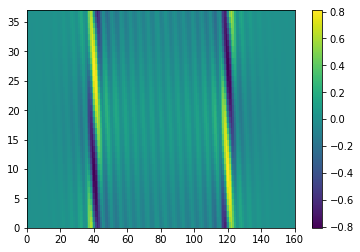

In [532]:

plt.pcolor(populations)

plt.colorbar()



0.0294195852156
1.60458105924
1.57079632679


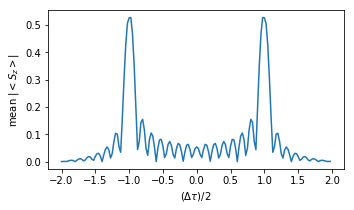

In [537]:
plt.figure(figsize= (5,3))
plt.plot(d_primes,np.mean(np.abs(populations.transpose()),axis= 1))
print(np.max(populations.transpose()[20]))
print(1/0.88136 * np.sqrt(2))
print(np.pi/2)
plt.ylabel('mean ${|<S_z>|}$')
plt.xlabel('$(\Delta \\tau )/ 2$')
#plt.ylabel('phase [rad]')

plt.tight_layout(pad=1)
plt.savefig('mollow-absorption-amplitude-phase-average-15-pulses.pdf')

In [536]:
np.save('mollow-phase-pulses',[populations,d_primes,phases])

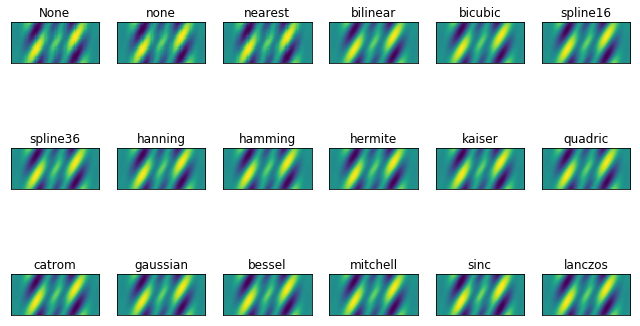

In [469]:
import matplotlib.pyplot as plt
import numpy as np

methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

# Fixing random state for reproducibility
np.random.seed(19680801)

grid = populations

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

x = phases
y = d_primes
for ax, interp_method in zip(axs.flat, methods):
    ax.imshow(grid, interpolation=interp_method, cmap='viridis')
    ax.set_title(str(interp_method))

plt.tight_layout()
plt.show()


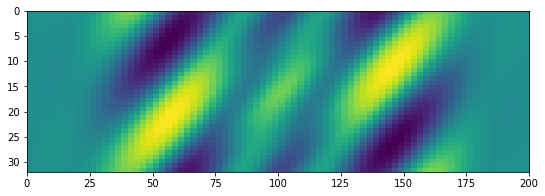

([<matplotlib.axis.XTick at 0x7f0f897e0210>,
 <a list of 7 Text xticklabel objects>)

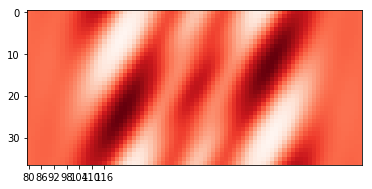

In [480]:
fig, ax = plt.subplots(figsize=(9,6))


ax.imshow(hist, interpolation='none', extent=[0,200,32,0]) #, cmap=plt.cm.Reds
ax.set_aspect(2) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
plt.show()

import matplotlib.pyplot as plt

# ... define 2D array hist as you did

plt.imshow(hist, cmap='Reds')
x = np.arange(80,122,2) # the grid to which your data corresponds
nx = x.shape[0]
no_labels = 7 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = x[::step_x] # labels you want to see
plt.xticks(x_positions, x_labels)

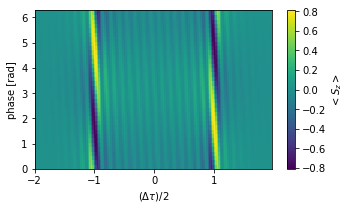

In [535]:
plt.figure(figsize= (5,3))

d_phase_slice =2 *  np.pi/float(points)
d_dprime_slice = 4 /float(160)
y,x = np.mgrid[slice(0,2 * np.pi + d_phase_slice,d_phase_slice) , 
slice(-2,2 ,d_dprime_slice) ]

plt.pcolor(x,y,populations)
plt.colorbar(label = '$<S_z>$')
plt.xlabel('$(\Delta \\tau )/ 2$')
plt.ylabel('phase [rad]')

plt.tight_layout(pad=1)

plt.savefig('phase-sweep-mollow-15-pulses.pdf')


In [3]:
Omega = w_larmor 

H0 = Omega * sx + w_larmor*iz + 0.5*sz*Axx*ix

print(rho_nv)
print(rho_total)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0.5]
 [ 0.5  0.5]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.25012494  0.          0.25012494  0.        ]
 [ 0.          0.24987506  0.          0.24987506]
 [ 0.25012494  0.          0.25012494  0.        ]
 [ 0.          0.24987506  0.          0.24987506]]


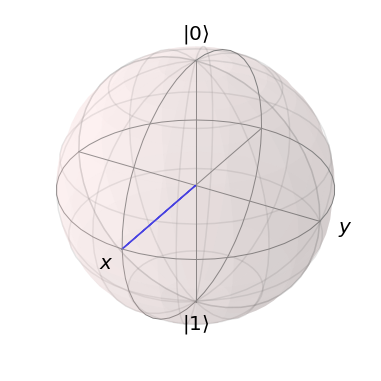

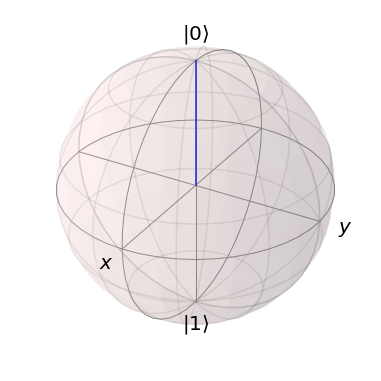

In [6]:
b3d = q.Bloch()
b3d2 = q.Bloch()
#for st in resultat.states:
for op,bl in zip([[sx,sy,sz],[ix,iy,iz]],[b3d,b3d2]):
    bl.add_points(points=np.array([q.expect(op[0],resultat.states),q.expect(op[1],resultat.states),q.expect(op[2],resultat.states)]), meth='l')
b3d.show()
b3d2.show()

b3d.fig.savefig('Bloch.png')
b3d2.fig.savefig('Bloch_nucl.png')

In [7]:
b_nv = q.Bloch()
b_nucl = q.Bloch()

b_nv.vector_color = ['r']
b_nucl.vector_color = ['b']

for op,bl in zip([[sx,sy,sz],[ix,iy,iz]],[b_nv, b_nucl]):
    b_nv.clear()
    b_nucl.clear()
    
    bl.add_vectors(np.array([q.expect(op[0],resultat.states),q.expect(op[1],resultat.states),q.expect(op[2],resultat.states)]))
    bl.add_points(points=np.array([q.expect(op[0],resultat.states),q.expect(op[1],resultat.states),q.expect(op[2],resultat.states)]),meth='l')
    
for i in range(len(resultat.states)):
    b_nv.clear()
    b_nucl.clear()
    
    b_nv.add_vectors(np.array([q.expect(sx,resultat.states[i]),q.expect(sy,resultat.states[i]),q.expect(sz,resultat.states[i])]))
    b_nucl.add_vectors(np.array([q.expect(ix,resultat.states[i]),q.expect(iy,resultat.states[i]),q.expect(iz,resultat.states[i])]))
    
    b_nv.save(dirc='temp')
    b_nucl.save(dirc='temp1')

In [11]:
import sys
from PIL import Image

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

image_folder1 = '/home/striebel/Documents/Jupyter_notebooks/temp/'
image_folder2 = '/home/striebel/Documents/Jupyter_notebooks/temp1/'

images1 = [img for img in os.listdir(image_folder1) if img.endswith(".png")]
images1.sort(key=natural_keys)

images2 = [img for img in os.listdir(image_folder2) if img.endswith(".png")]
images2.sort(key=natural_keys)

for i in range(5):

    images = map(Image.open, [image_folder1+images1[i], image_folder2+images2[i]])
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save('new_' + str(i) + '.png')

In [12]:
for i in range(len(images1)):

    images = map(Image.open, [image_folder1+images1[i], image_folder2+images2[i]])
    
    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save('new_' + str(i) + '.png')

In [13]:
image_folder = '/home/striebel/Documents/Jupyter_notebooks/'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort(key=natural_keys)

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 20, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()